### Load Libraries & Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.signal import cont2discrete
import pickle
import matplotlib.pyplot as plt

In [12]:
x = np.random.rand(20).reshape((2,10))
y = np.random.rand(20).reshape((2,10))

print(x[1,:])
print()
print(x[1])

[0.29185213 0.99317607 0.39833841 0.40900266 0.75069576 0.62422617
 0.70996278 0.34413864 0.50186632 0.34648652]

[0.29185213 0.99317607 0.39833841 0.40900266 0.75069576 0.62422617
 0.70996278 0.34413864 0.50186632 0.34648652]


### Import Data

In [2]:
with open('3_grey-box-modelling_data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'] # indoor air temperature in degC
To = Data['To'] # outdoor air temperature in degC
q_HVAC = Data['q_HVAC'] # HVAC heating rate in W
q_solar = Data['q_solar'] # absorbed solar radiation in W

### Define functions for grey-box modelling (system identification)
Here, you need to define (i) A and B matrixes and (ii) error metric for the parameter estimation

In [3]:
def simulation(Ci, Cw, R1, R2, R3):
    # continuous time invariant state-space
    A = np.array([[-1/(Ci*R1),1/(Ci*R1)],[1/(Cw*R1), -1/(Cw*R1)-1/(Cw*R2)+R3/(Cw*R2*(R2+R3))]])
    B = np.array([[1/Ci,0,0],[0,(R2*R3)/(Cw*R2*(R2+R3)),R2/(Cw*R2*(R2+R3))]])
    C = np.eye(2)
    D = np.zeros((2,3))
    
    # discrete state-space
    Ad, Bd, Cd, Dd, _ = cont2discrete((A,B,C,D), 10*60) # 10 minute time interval
    
    x = np.zeros((2, N+1))
    x[0,0] = 20 # initial Ti
    x[1,0] = 15 # initial Tw
    
    # compute states over the simulation period
    for i in range(N):
        q_HVAC_t = q_HVAC[i]
        q_solar_t = q_solar[i]
        To_t = To[i]
        u_t = np.array([q_HVAC_t, q_solar_t, To_t])[:,None] # input vector
        x[:,i+1:i+2] = np.dot(Ad,x[:,i:i+1]) + np.dot(Bd,u_t)
    return x

def objective(params):
    # scaled for better optimization
    Ci = params[0] * 1000000
    Cw = params[1] * 10000000
    R1 = params[2] * 0.001
    R2 = params[3] * 0.001
    R3 = params[4] * 0.001
    
    # run simulation
    x = simulation(Ci, Cw, R1, R2, R3)
    
    # error metric
    metric = ((np.mean((Ti - x[0,:])**2))**0.5)

    return metric

In [4]:
N = To.shape[0] # number of timesteps

# parameter estimation
init = np.array([1,1,5,1,5]) # initial value for the optimization below
ans = minimize(objective, # using a 
               init,
               options={'maxiter':1000,
                        'gtol':1e-1
                        })
params = ans.x # estimated parameters

Ci: 2694139.401168574
Cw: 17586521.668661855
R1: 0.0076327951362859464
R2: 0.001762366784703318
R3: 0.005917957215268885


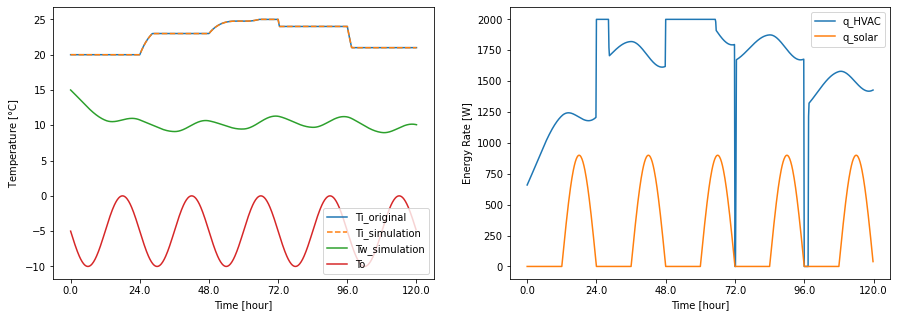

In [5]:
# scale them back
Ci = params[0] * 1000000
Cw = params[1] * 10000000
R1 = params[2] * 0.001
R2 = params[3] * 0.001
R3 = params[4] * 0.001

print('Ci:',Ci)
print('Cw:',Cw)
print('R1:',R1)
print('R2:',R2)
print('R3:',R3)

x = simulation(Ci, Cw, R1, R2, R3)

Ti_simulation = x[0,:] # Indoor temperature 
Tw_simulation = x[1,:]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ti, label='Ti_original')
ax[0].plot(Ti_simulation, label='Ti_simulation', linestyle='--')
ax[0].plot(Tw_simulation, label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(q_HVAC, label='q_HVAC')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()